In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt


In [14]:
# Imports
installs = pd.read_csv("../data/installs.csv", parse_dates=["install_date"])
sessions = pd.read_csv("../data/sessions.csv", parse_dates=["session_date"])
purchases = pd.read_csv("../data/purchases.csv", parse_dates=["purchase_date"])
retention = pd.read_csv("../data/retention.csv", parse_dates=["install_date"])

# İlk 5 satırı göster
print("Installs:")
print(installs.head())

print("\nSessions:")
print(sessions.head())

print("\nPurchases:")
print(purchases.head())

print("\nRetention:")
print(retention.head())

Installs:
  user_id    platform install_date
0  user_0      TikTok   2025-06-28
1  user_1  Google UAC   2025-06-30
2  user_2        Meta   2025-07-04
3  user_3      TikTok   2025-07-17
4  user_4      TikTok   2025-06-29

Sessions:
  user_id session_date
0  user_0   2025-07-13
1  user_1   2025-07-12
2  user_1   2025-06-24
3  user_1   2025-07-01
4  user_2   2025-07-07

Purchases:
    user_id purchase_date  amount     item
0  user_896    2025-07-13    2.63  booster
1  user_104    2025-07-07   39.65    lives
2  user_330    2025-07-16   12.52     skin
3  user_812    2025-07-18   24.69     skin
4  user_510    2025-07-02   38.18     skin

Retention:
  user_id install_date  d1_retained  d7_retained  d30_retained
0  user_0   2025-07-15            0            0             0
1  user_1   2025-07-06            1            0             0
2  user_2   2025-07-06            1            0             1
3  user_3   2025-06-30            1            0             0
4  user_4   2025-07-10            

In [15]:
# Number of sessions per user in the first 3 days

sessions_3d = sessions.merge(installs[['user_id', 'install_date']], on='user_id')
sessions_3d['diff_days'] = (sessions_3d['session_date'] - sessions_3d['install_date']).dt.days
sessions_3d_filtered = sessions_3d[sessions_3d['diff_days'] <= 3]
session_counts = sessions_3d_filtered.groupby('user_id').size().reset_index(name='session_count_3d')

In [16]:
# Number of early purchases and total amount in the first 3 days

purchases_3d = purchases.merge(installs[['user_id', 'install_date']], on='user_id')
purchases_3d['diff_days'] = (purchases_3d['purchase_date'] - purchases_3d['install_date']).dt.days
purchases_3d_filtered = purchases_3d[purchases_3d['diff_days'] <= 3]
early_purchases = purchases_3d_filtered.groupby('user_id').agg(
    early_purchase_count=('amount', 'count'),
    early_purchase_amount=('amount', 'sum')
).reset_index()

In [17]:
# Retentions (d1, d7, d30)

retention_feats = retention[['user_id', 'd1_retained', 'd7_retained', 'd30_retained']]

In [18]:
# Target: Day 30 total purchases (LTV proxy)

total_purchases = purchases.groupby('user_id')['amount'].sum().reset_index(name='ltv_30d')

In [19]:
# Feature set

features = installs[['user_id']].merge(session_counts, on='user_id', how='left') \
    .merge(early_purchases, on='user_id', how='left') \
    .merge(retention_feats, on='user_id', how='left') \
    .merge(total_purchases, on='user_id', how='left')

# Fill in missing values

features.fillna(0, inplace=True)

In [20]:
X = features.drop(columns=['user_id', 'ltv_30d'])
y = features['ltv_30d']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
# Prediction
y_pred = model.predict(X_test)

y_pred = np.clip(y_pred, 0, None)

In [29]:
# Performance measurement

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 5.0215
RMSE: 9.4173


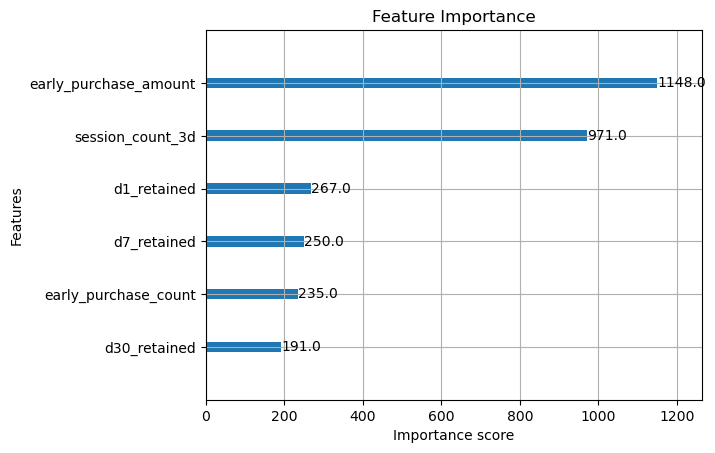

In [30]:
# Feature importance chart

xgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance")
plt.show()

In [31]:
# Compare predicted and reel values

results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
print(results.head())

     y_test     y_pred
521    0.00   0.000000
737   32.97  32.008633
740    3.62   6.148181
660    0.00   3.310638
411    0.00   0.028437


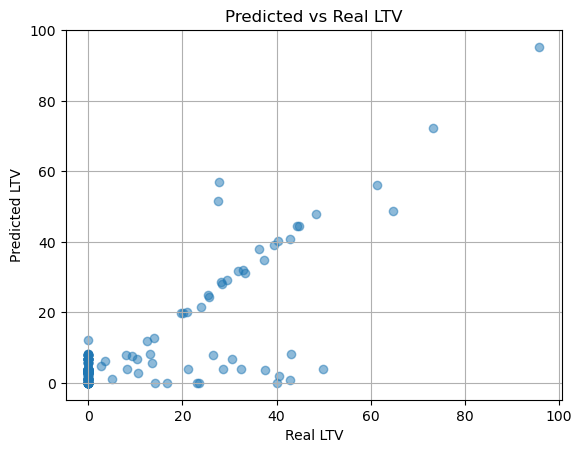

In [37]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Real LTV")
plt.ylabel("Predicted LTV")
plt.title("Predicted vs Real LTV")
plt.grid(True)
plt.show()